In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


# 1. Data Preprocessing

## 1.1. Mounting Drive

In [22]:
from google.colab import drive
import os
drive.mount('/content/drive')

# adjust path with the dataset in google drive
drive_data_path = '/content/drive/MyDrive/capstone/dataset/dataset'

os.listdir(drive_data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['10000', '5000', '50000', '100000', '2000', '20000', '1000']

## 1.2. Parameters

In [23]:
#Specifying some parameters
class Config:
  class_names = ['5000', '10000', '50000'],
  num_classes = 3,
  img_height = 224,
  img_width  = 224,
  labels = "inferred",
  label_mode = "int",
  color_mode = "rgb",
  batch_size = 32,
  # dir_type = ['training', 'development','validation']
  dir_type = ['training','validation']

## 1.3. Declaring Source Directory Path

In [24]:
#creating a dictionary consist of source directory's path
def creating_source_path(dir_base):
  source_dir = {}

  for names in Config.class_names[0]:
    source_dir['dir_' + names] = os.path.join(dir_base, names)

  return  source_dir

In [25]:
#dataset source path
dir_base = '/content/drive/MyDrive/capstone/dataset/dataset'

source_dir =  creating_source_path(dir_base)

print(source_dir)

{'dir_5000': '/content/drive/MyDrive/capstone/dataset/dataset/5000', 'dir_10000': '/content/drive/MyDrive/capstone/dataset/dataset/10000', 'dir_50000': '/content/drive/MyDrive/capstone/dataset/dataset/50000'}


In [26]:
#checking dataset

def check_source_dir(source_dir):
  for key, value in source_dir.items():
    print(f'total {key} rupiah images: ', len(os.listdir(value)))

check_source_dir(source_dir)

total dir_5000 rupiah images:  691
total dir_10000 rupiah images:  637
total dir_50000 rupiah images:  582


In [27]:
for value in source_dir.values():
    print(value)

/content/drive/MyDrive/capstone/dataset/dataset/5000
/content/drive/MyDrive/capstone/dataset/dataset/10000
/content/drive/MyDrive/capstone/dataset/dataset/50000


In [29]:
import shutil

# Define the class names
class Config:
    class_names = [['5000', '10000', '50000']]

def create_dirs(root_path):
    path_dir = {}
    for names in Config.class_names[0]:
        path_dir['dataset_' + names] = os.path.join('working_dataset', names)

    # Delete existing directories
    for path in path_dir.values():
        if os.path.exists(path):
            shutil.rmtree(path)
            print(f"The directory {path} has been deleted.")
        else:
            print(f"The directory {path} does not exist.")

    # Create new directories
    for path in path_dir.values():
        try:
            os.makedirs(path)
            print(path, 'created')
        except:
            print(path, 'failed')
    pass

creating_dir = ""

dataset = '/content/drive/MyDrive/working_dataset'

try:
    create_dirs(root_path=creating_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

The directory working_dataset/5000 has been deleted.
The directory working_dataset/10000 has been deleted.
The directory working_dataset/50000 has been deleted.
working_dataset/5000 created
working_dataset/10000 created
working_dataset/50000 created


## 1.4. Load Dataset with ImageDataGenerator

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                               brightness_range = (0.5, 1.5),
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               rotation_range = 20,
                               validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)



train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training')

valid_generator = valid_datagen.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation')

Found 1529 images belonging to 3 classes.
Found 381 images belonging to 3 classes.


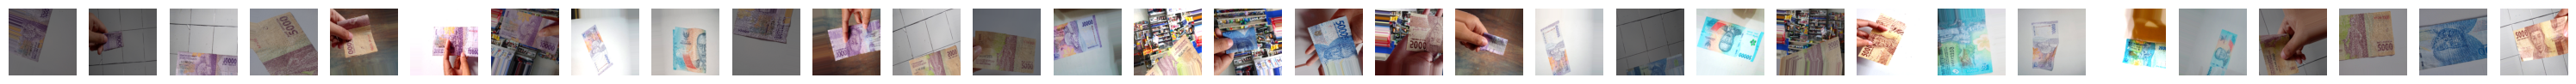

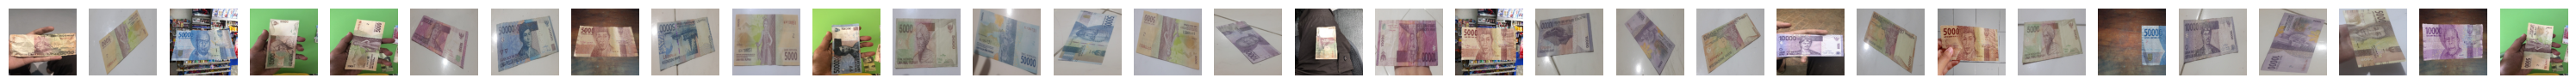

In [32]:
#Checking Loaded Image After Augmentation

import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load one batch of training data
train_images, train_labels = next(train_generator)

# Plot the training images
plot_images(train_images)

# Load one batch of validation data
val_images, val_labels = next(valid_generator)

# Plot the validation images
plot_images(val_images)

In [33]:
images, labels = next(train_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32,)


In [34]:
# Transform it to Dataset type

train_ds = tf.data.Dataset.from_generator(
     lambda: train_datagen.flow_from_directory(
         dir_base,
         target_size=(224, 224),
         batch_size=32,
         class_mode='categorical',
         subset='training'
         ),
     output_signature=(
       tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
       tf.TensorSpec(shape=(32, 7), dtype=tf.float32, name=None)
    )
 )

valid_ds = tf.data.Dataset.from_generator(
     lambda: valid_datagen.flow_from_directory(
         dir_base,
         target_size=(224, 224),
         batch_size=32,
         class_mode='categorical',
         subset='validation'
         ),
     output_signature=(
       tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
       tf.TensorSpec(shape=(32, 7), dtype=tf.float32, name=None)
    )
 )

In [35]:
# #for prefetching and caching performance purpose
AUTOTUNE = tf.data.AUTOTUNE

# Function to convert DirectoryIterator to tf.data.Dataset
def convert_to_tf_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: (x for x in generator),
        output_signature=(
            tf.TensorSpec(shape=generator.image_shape, dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    return dataset

# Convert generators to tf.data.Dataset
train_ds = convert_to_tf_dataset(train_generator)
val_ds = convert_to_tf_dataset(valid_generator)

# Apply caching and prefetching
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 2. Creating Model

In [36]:
#creating checkpoints and earlystopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = 'checkpoint\\model-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                              monitor='val_accuracy',
                              mode='max',
                              save_best_only=True,
                              verbose=1
                             )

callbacks = EarlyStopping(monitor = 'loss', patience = 3, verbose = 1)

## 2.1. CNN Model

In [37]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, GlobalMaxPooling2D, Dropout, AveragePooling2D

class Config:
    img_height = 224
    img_width = 224

model = Sequential([
    Input(shape = (Config.img_height, Config.img_width, 3)),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(7)


])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 32)       

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [40]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [41]:
model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[callbacks, checkpoint]
)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.0470 - accuracy: 0.4807 
Epoch 1: val_accuracy improved from -inf to 0.72441, saving model to checkpoint\model-01-0.7244.keras
48/48 [==============================] - 539s 11s/step - loss: 1.0470 - accuracy: 0.4807 - val_loss: 0.7642 - val_accuracy: 0.7244
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7168 
Epoch 2: val_accuracy improved from 0.72441 to 0.76378, saving model to checkpoint\model-02-0.7638.keras
48/48 [==============================] - 533s 11s/step - loss: 0.6756 - accuracy: 0.7168 - val_loss: 0.6298 - val_accuracy: 0.7638
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.8116 
Epoch 3: val_accuracy improved from 0.76378 to 0.80840, saving model to checkpoint\model-03-0.8084.keras
48/48 [==============================] - 536s 11s/step - loss: 0.4641 - accuracy: 0.8116 - val_loss: 0.6072 - val_accuracy: 0.8084
Epoch 4/20

In [42]:
model.save("currency_sense_model")

In [43]:
converter = tf.lite.TFLiteConverter.from_saved_model("currency_sense_model")
tflite_model = converter.convert()

In [44]:
tflite_model_name = "currency_sense_model.tflite"
with open(tflite_model_name, "wb") as f:
    f.write(tflite_model)

In [45]:
model.save('currency_sense_model.keras')